# Imports

In [84]:
import os

import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from dotenv import load_dotenv, find_dotenv
from openai import OpenAI

import utility.utility as util
import utility.prompts as prompts
import utility.text_cleaning as tc

import json

# Progress Bars:
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

# Below import and instructions simply for display
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# resets import once changes have been applied
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Configuration

In [110]:
"""
"gpt-3.5-turbo-0125"
"gpt-4-0125-preview"
"""
_model = "gpt-3.5-turbo-0125"

"""

"""
_min_ratio = .5

"""
Few shot settings
"""
_incl_sentence = True
_flag_UA = True
_flag_segmented = True

"""
Segmentation Settings
"""
_max_token_num = 15900
_overlay = 200

"""

"""
_examples_file = "examples_altered.xlsx"
_test_file =

SyntaxError: EOF while scanning triple-quoted string literal (2320313233.py, line 25)

# Aux Info

In [109]:
cost_per_1k_tokens = {"gpt-3.5-turbo-0125":0.0005, "gpt-4-0125-preview":0.01}

# Directory and File Paths

In [86]:
path_data = os.path.join(os.getcwd(), "data")

path_stmts = os.path.join(path_data, "predict")

file_excel = os.path.join(path_data, _examples_file)

# Load Environment Variables

In [87]:
_ = load_dotenv(find_dotenv())

# Load Data

In [88]:
df_meta = pd.read_excel(file_excel, sheet_name="Sheet1")

# Data Prep

In [89]:
df_meta.dropna(axis=1, inplace=True, thresh = int(df_meta.shape[0]*.1))
df_meta.drop(columns=["checked by", "new", "manual", "page (txt)", "manual", "note"], inplace=True)
df_meta["filename"] = df_meta["filename"].astype("str") + ".txt"
df_meta["filepath"] = df_meta["filename"].apply(lambda x: os.path.join(path_stmts, x))

# Split "Train" "Test"

In [90]:
prompt_indeces = [0,1,2,3,4,5,6,7,16,17,20,21,26,27,34,35,36,37]
test_indeces = [i for i in df_meta.index if i not in prompt_indeces]

In [91]:
# Fill this dataframe with the examples used in few-shot prompting
prompt_df = df_meta.iloc[prompt_indeces,:].copy()
# Fill this dataframe with the inference samples
test_df = df_meta.iloc[test_indeces,:].copy()
del df_meta

# Construct Base Prompt

### Extract most common terms:

In [93]:
# Extract terms that are commonly found in respective sections
terms_auditor = util.concat_terms(util.det_commonly_used_terms(prompt_df["terms_audit"], min_ratio=_min_ratio), ", ")
terms_notes = util.concat_terms(util.det_commonly_used_terms(prompt_df["terms_notes"], min_ratio=_min_ratio), ", ")
#terms_acc_stds = util.concat_terms(util.det_commonly_used_terms(df_meta["term"], min_ratio=0), " - ")

# Add terms to prompt
section_terms_auditor = prompts.common_terms_section_auditor.format(terms_auditor = terms_auditor)
section_terms_notes = prompts.common_terms_section_notes.format(terms_notes = terms_notes)
#section_terms_acc_stds = prompts.common_terms_accounting_stds.format(acc_std = terms_acc_stds)

### System Context

In [97]:
system_unsegmented = prompts.system_context_basic + \
         prompts.task_descr_1 + \
         section_terms_auditor + \
         section_terms_notes + \
         prompts.instruction_1 + \
         prompts.answer_format1

system_segmented = prompts.system_context_basic + \
         prompts.task_descr_2 + \
         section_terms_auditor + \
         section_terms_notes + \
         prompts.instruction_2 + \
         prompts.answer_format2

system = system_segmented

### FewShot examples

In [98]:
user_assistant, prompt_examples = util.prep_fs_examples(df=prompt_df, 
                                                        id_col="filename", 
                                                        source_col="source", 
                                                        paragraph_col="paragraph (context)", 
                                                        sentence_col="sentence",
                                                        standard_col="term", 
                                                        incl_sentence=True, 
                                                        flag_UA=False, 
                                                        flag_segmented=True, 
                                                        base_prompt=prompts.examples_base1)
system += prompt_examples

### Token length system and UA context

In [101]:
base_token_length = util.count_tokens(system)
if user_assistant:
    for ua in user_assistant:
        base_token_length += util.count_tokens(ua[0]) + util.count_tokens(ua[1])

# Prepare Inputs

In [102]:
df_inputs = util.prep_inputs(test_df, 
                             'filepath', 
                             'filename',  
                             ['filepath', 'filename', 'cc_iso3'], 
                             base_token_length, 
                             _flag_segmented,
                             _max_token_num, 
                             _overlay)

# Stats

## Token Number Distribution

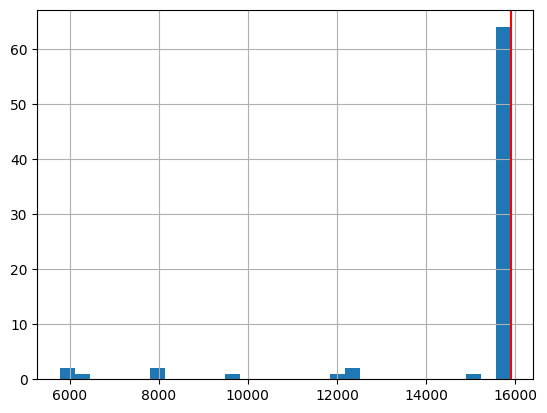

In [103]:
df_inputs['total_tokens'].hist(bins=30)
plt.axvline(x=df_inputs['total_tokens'].median(), color = "r")

## Costs

In [104]:
util.calc_price_gpt(df_inputs.shape[0],
                    df_inputs.total_tokens.mean(),
                    1,
                    cost_per_1k_tokens[_model])

{'$ (excl. VAT)': 0.5565734999999999}

## Computation Time

In [105]:
util.calc_compute_time(df_inputs.shape[0],
                       df_inputs.total_tokens.mean(),
                       1,
                       1_000_000)

{'days': 0.0, 'hours': 0.0, 'min': 1.113147, 'raw min': 1.113147}

# Prompt GPT

## Initialize Client

In [107]:
client = OpenAI()

## Call API

In [108]:
df_inputs['output'] = df_inputs.progress_apply(lambda x: util.prompt_gpt(client, system, x.prompt, user_assistant, _model), axis=1)

  0%|          | 0/74 [00:00<?, ?it/s]

# Evaluation

In [111]:
df_inputs

,filepath,filename,cc_iso3,prompt,prompt_tokens,total_tokens,segment,output
0,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,SGP,CEI Contract Manufacturing Limited Company Reg...,10615,15900,0,ChatCompletion(id='chatcmpl-9264S1PXyfG9D40xHz...
1,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,SGP,their fair values in other comprehensive inco...,10615,15900,1,ChatCompletion(id='chatcmpl-9264VS5ryGUESrCDWz...
2,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,SGP,exposed to equity price risk arising from its...,10615,15900,2,ChatCompletion(id='chatcmpl-9264YsJ01FWHECN7WP...
3,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,SGP,"laws, or in the interpretation of these laws ...",664,5949,3,ChatCompletion(id='chatcmpl-9264aQCPDyNlqVJK7a...
4,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61511488.txt,SGP,"Transcending Boundaries, Growing Opportunities...",10615,15900,0,ChatCompletion(id='chatcmpl-9264hKD2DSpfIzALIn...
...,...,...,...,...,...,...,...,...
69,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,60783048.txt,FRA,"taking into account, in the event of separate...",9853,15138,7,ChatCompletion(id='chatcmpl-926KiPdRme58TLCCeT...
70,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61015098.txt,GBR,ANNUAL REPORT & ACCOUNTS AVESCO GROUP PLC ANNU...,10615,15900,0,ChatCompletion(id='chatcmpl-926KxekLEmec9CqbEM...
71,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61015098.txt,GBR,it in prior to its introduction to the Offici...,10615,15900,1,ChatCompletion(id='chatcmpl-926LFddX5Q9dlgOJja...
72,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61015098.txt,GBR,continued operations Share of associates' oper...,10615,15900,2,ChatCompletion(id='chatcmpl-926LUJGlCl1K6EK1eM...


In [38]:
files = df_inputs.filename.values
labels = test_df[test_df.filename.isin(files)].copy()
labels[['found_sentence', 'found_term']] = ""

files = df_inputs.filename.values
labels = test_df[test_df.filename.isin(files)].copy()
labels[['found_sentence', 'found_term']] = ""

In [39]:
for row in df_inputs.index:
    d = json.loads(df_inputs.loc[row]["output"].choices[0].message.content)
    id = df_inputs.loc[row].filename
    
    for k, v in d.items():
        mask = (labels['filename'] == id) & (labels['source'] == k)
        labels.loc[mask, 'found_sentence'] = v['sentence'] 
        labels.loc[mask, 'found_term'] = v['term']

# Eval Segmented

In [195]:
from pprint import pprint
i = 6
for row in df_inputs_segmented.index[i:i+1]:
    d = json.loads(df_inputs_segmented.loc[row]["output"].choices[0].message.content)
    id = df_inputs_segmented.loc[row].filename
    
    print(id)
    pprint(d)

61511488.txt
{'audit': {'sentence': 'In determining fair value less costs to sell, an '
                       'appropriate valuation model is used.',
           'term': 'no answer'},
 'notes': {'sentence': 'The financial statements of the Group and of the '
                       'Company have been prepared in accordance with '
                       'Financial Reporting Standards and the requirements of '
                       'the Companies Act, 1965 in Malaysia. ',
           'term': 'Financial Reporting Standards and the requirements of the '
                   'Companies Act, 1965 in Malaysia.'}}


In [117]:
df_inputs_segmented

,filepath,filename,cc_iso3,prompt,num_tokens,com_num_tokens,segment,output
0,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,SGP,CEI Contract Manufacturing Limited Company Reg...,10828,15900,0,ChatCompletion(id='chatcmpl-90VuFg6xQ2YdEQhI8P...
1,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,SGP,impairment in accordance with FRS Impairment ...,10828,15900,1,ChatCompletion(id='chatcmpl-90VuLAHzy2KQKpdBNc...
2,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,SGP,sensitivity to a reasonably possible change i...,10653,15725,2,ChatCompletion(id='chatcmpl-90VuQRXBt54OvlmSUL...
3,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61511488.txt,SGP,"Transcending Boundaries, Growing Opportunities...",10828,15900,0,ChatCompletion(id='chatcmpl-90VuUQLRsi51NITtmd...
4,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61511488.txt,SGP,LTD Annual Report Corporate Governance Report...,10828,15900,1,ChatCompletion(id='chatcmpl-90VufDQBdPejKa75iF...
...,...,...,...,...,...,...,...,...
66,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,60783048.txt,FRA,with legal and regulatory provisions ; (viii)...,8362,13434,7,ChatCompletion(id='chatcmpl-90WA9lILKSPhc0A64Y...
67,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61015098.txt,GBR,ANNUAL REPORT & ACCOUNTS AVESCO GROUP PLC ANNU...,10828,15900,0,ChatCompletion(id='chatcmpl-90WAQMxGLGuTKGdimU...
68,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61015098.txt,GBR,Avesco in and was appointed to the Board in H...,10828,15900,1,ChatCompletion(id='chatcmpl-90WAgo9TcpPq6G93r4...
69,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61015098.txt,GBR,investments is in respect of the profit made ...,10828,15900,2,ChatCompletion(id='chatcmpl-90WAxYsUZHUhTYPcR6...
